In [245]:
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl
from utils.plot_utils import shiftedColorMap, template_reorder
from utils.opto_utils import opto_metrics
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import spikeinterface.widgets as sw
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline

In [246]:
session = 'behavior_751004_2024-12-22_13-09-17'
data_type = 'curated'
target = 'soma'
session_dir = session_dirs(session)
we = si.load(session_dir['postprocessed_dir_curated'], load_extensions=False)
y_loc = we.get_extension('unit_locations').get_data()[:,1]

/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1109: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


In [249]:
unit_tbl = get_unit_tbl(session, data_type)
opto_tbl = unit_tbl
opto_tag = opto_metrics(session, data_type)
unit_ids = opto_tbl['unit_id'].values.tolist()
unit_ids = [int(unit_id) for unit_id in unit_ids]

In [250]:
p_max = []
p_mean = []
lat_max_p = []
lat_mean = []
euc_max_p = []
corr_max_p = []
bl_max_p = []
pass_count = []
for unit_id in unit_ids:
    curr_opto = opto_tag.load_unit(unit_id)
    # find ones with respond latencies
    sort_inds = np.argsort(curr_opto['resp_p_bl'].values)[::-1]
    for curr_ind in sort_inds:
        curr_max_p = curr_opto['resp_p_bl'].values[curr_ind]
        if not curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].isna().all():
            break
    if curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].isna().all():
        curr_max_p = curr_opto['resp_p_bl'].max()

    p_max.append(curr_max_p)
    p_max_ind = curr_opto['resp_p_bl'].idxmax()
    max_conditions = curr_opto[curr_opto['resp_p_bl']==curr_max_p]
    # count number of cases that passes the threshold, group by power, pre-post and duration
    count = curr_opto.groupby(['powers', 'stim_times', 'durations']).agg({'resp_p_bl': list})
    count = count.reset_index()
    count = pd.DataFrame(count)
    count_curr_all = []
    for row in count.iterrows():
        count_curr = np.sum(np.array(row[1]['resp_p_bl']) > 0.3)
        count_curr_all.append(count_curr)
    pass_count.append(np.max(count_curr_all))

    p_mean.append(np.nanmax(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['mean_p'].values))

    lat_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].values))
    lat_mean.append(curr_opto['resp_lat'].mean(skipna=True))
    euc_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['euclidean_norm'].values))
    corr_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['correlation'].values))
    bl_max_p.append(curr_opto.loc[p_max_ind]['resp_p'] - curr_opto.loc[p_max_ind]['resp_p_bl'])
amp = [np.max(temp) - np.min(temp) for temp in opto_tbl['waveform_mean']]
peak = [-np.min(temp) for temp in opto_tbl['waveform_mean']]
label = unit_tbl['decoder_label'].values
real_unit = label != 'artifact'
opto_tag_tbl = pd.DataFrame({'unit_id': unit_ids, 
                            'bl_max_p': bl_max_p,
                            'p_max': p_max, 
                            'p_mean': p_mean, 
                            'lat_max_p': lat_max_p, 
                            'lat_mean': lat_mean, 
                            'euc_max_p': euc_max_p, 
                            'corr_max_p': corr_max_p, 
                            'default_qc': opto_tbl['default_qc'].values,
                            'opto_pass': opto_tbl['opto_pass'].values,
                            'amp': amp, 
                            'peak': peak,
                            'decoder_label': label,
                            'real_unit': real_unit,
                            'y_loc': y_loc, 
                            'pass_count': pass_count})

/tmp/ipykernel_2718/4206192422.py:37: RuntimeWarning: All-NaN slice encountered
  euc_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['euclidean_norm'].values))
/tmp/ipykernel_2718/4206192422.py:38: RuntimeWarning: All-NaN slice encountered
  corr_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['correlation'].values))
/tmp/ipykernel_2718/4206192422.py:35: RuntimeWarning: All-NaN slice encountered
  lat_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].values))
/tmp/ipykernel_2718/4206192422.py:37: RuntimeWarning: All-NaN slice encountered
  euc_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['euclidean_norm'].values))
/tmp/ipykernel_2718/4206192422.py:38: RuntimeWarning: All-NaN slice encountered
  corr_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['correlation'].values))
/tmp/ipykernel_2718/4206192422.py:35: RuntimeWarning: All-NaN slice encountered
  lat_max_

/tmp/ipykernel_2718/2148385360.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x1000 with 0 Axes>

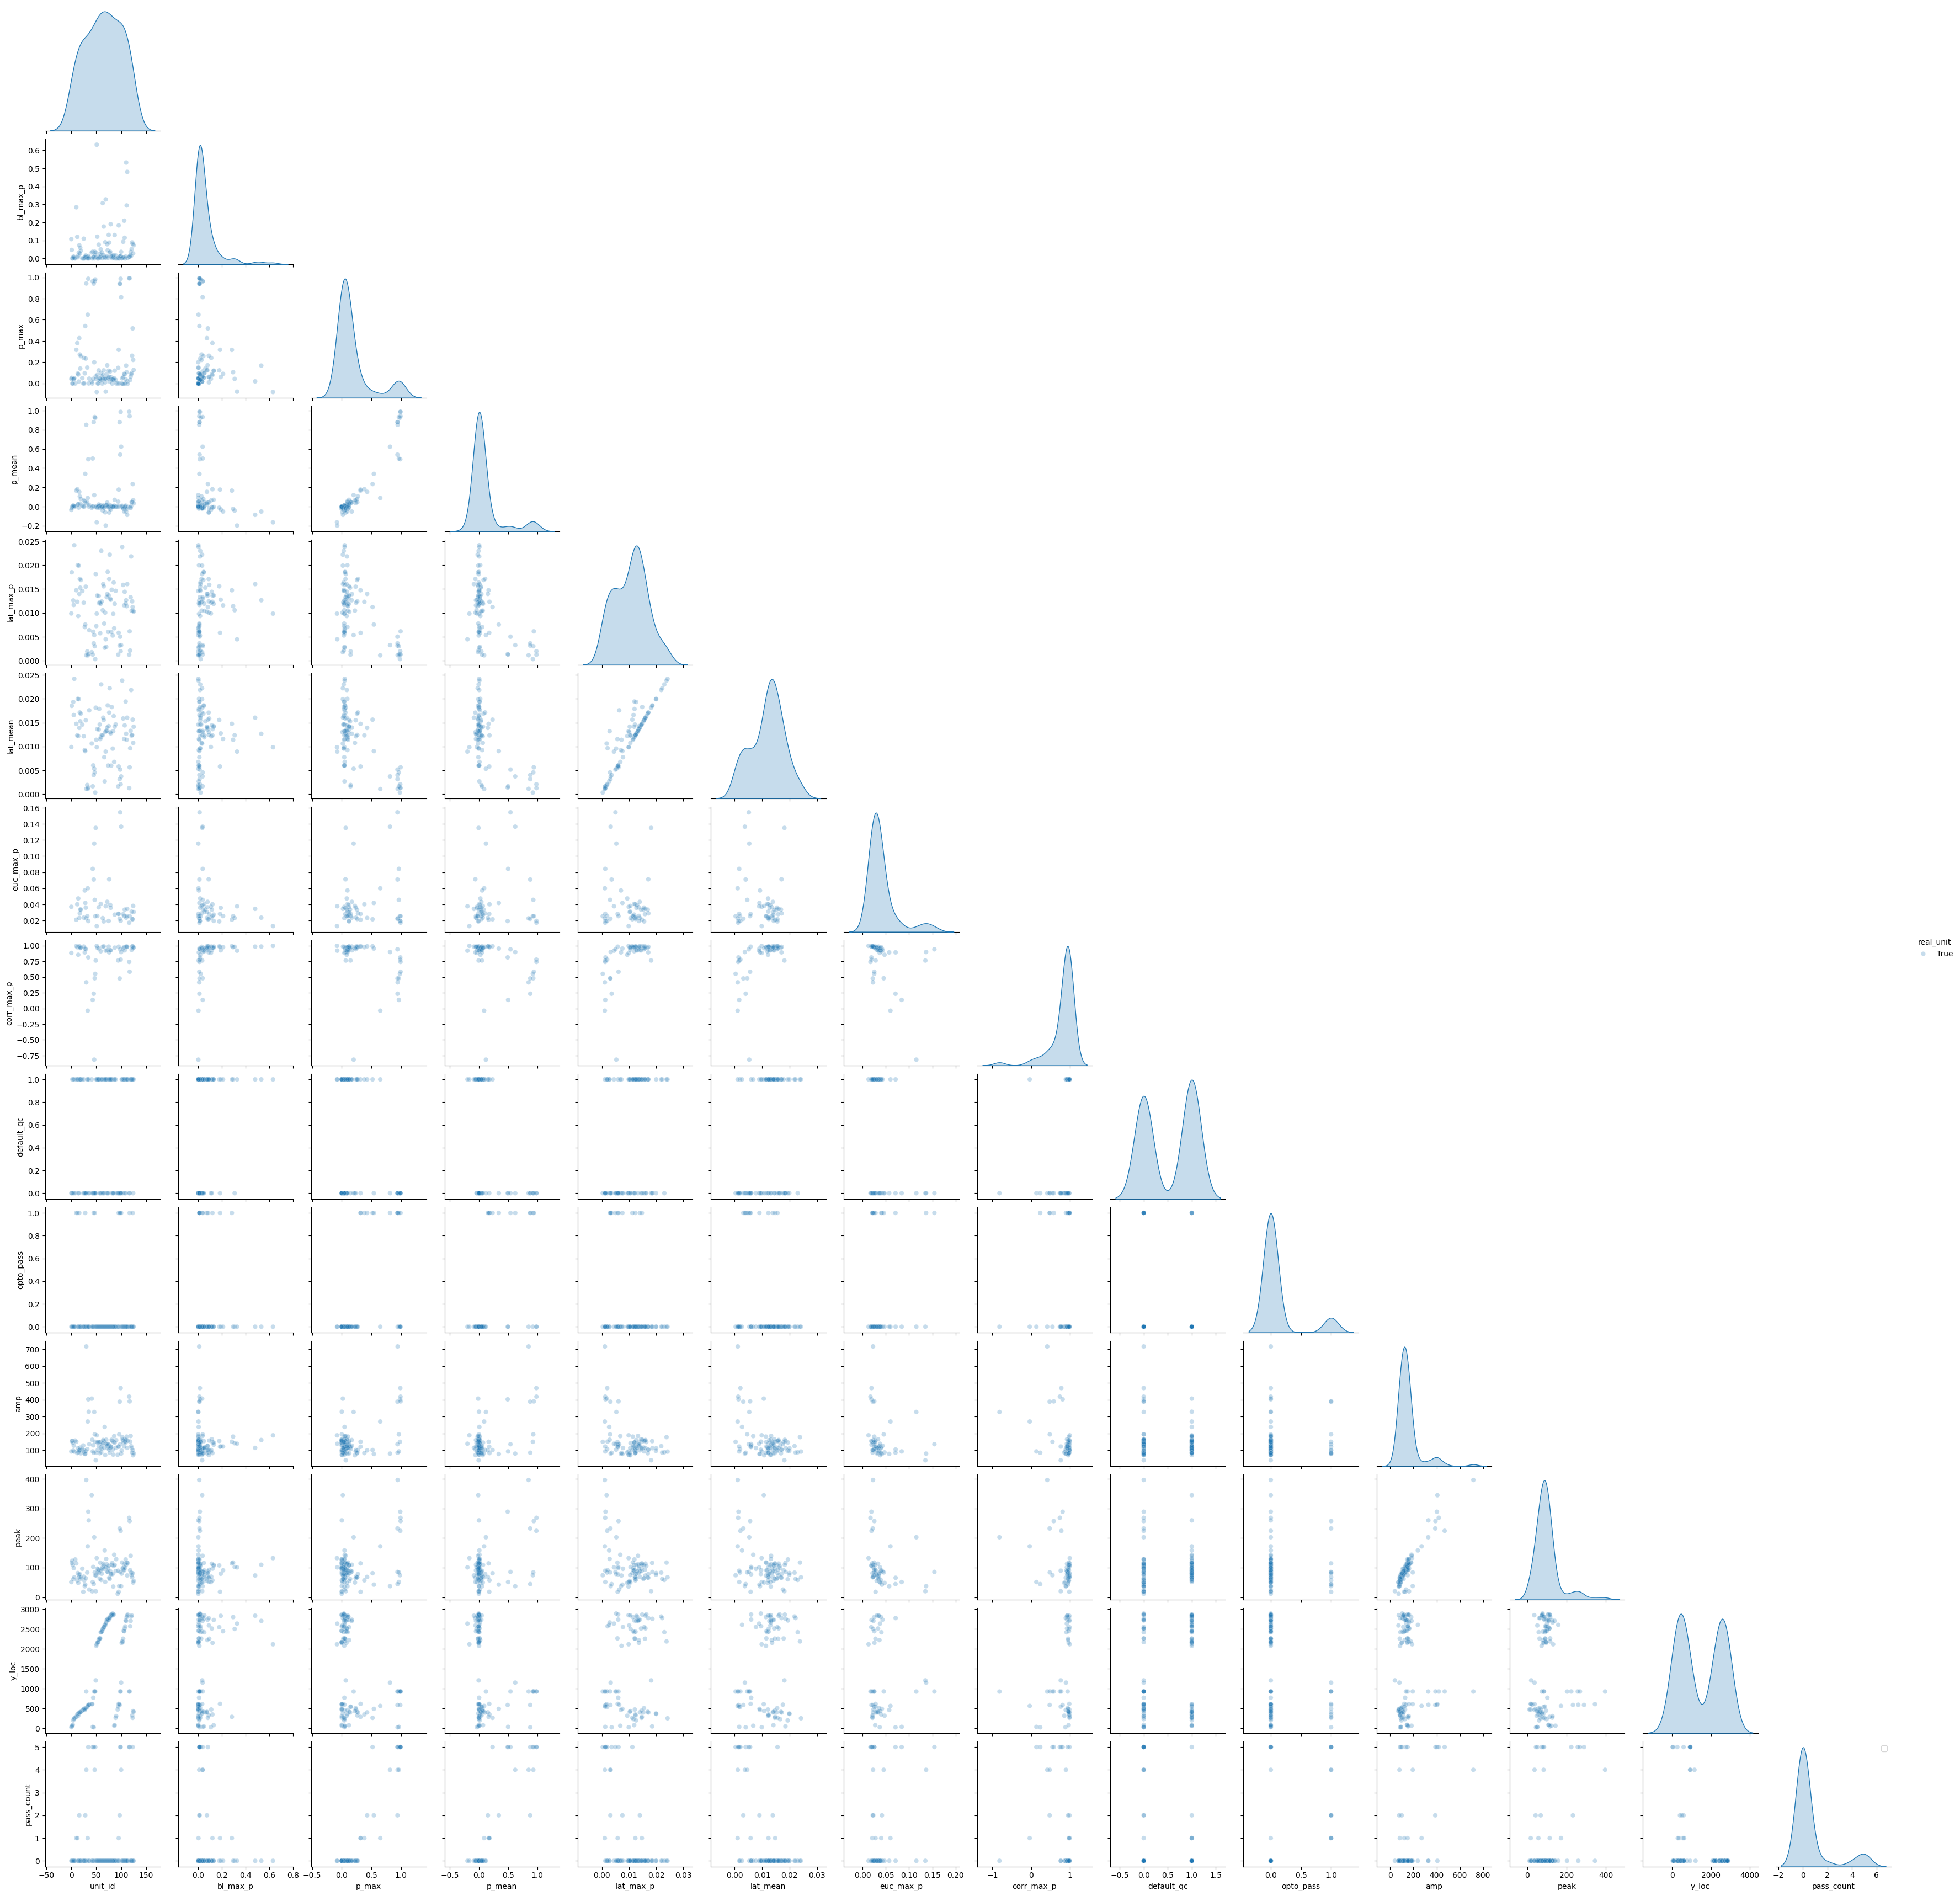

In [251]:
plt.figure(figsize=(10, 10))
sns.pairplot(opto_tag_tbl, hue='real_unit', corner=True, diag_kind='kde', plot_kws={'alpha': 0.25})
plt.legend() 

/tmp/ipykernel_2718/1448620630.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x1000 with 0 Axes>

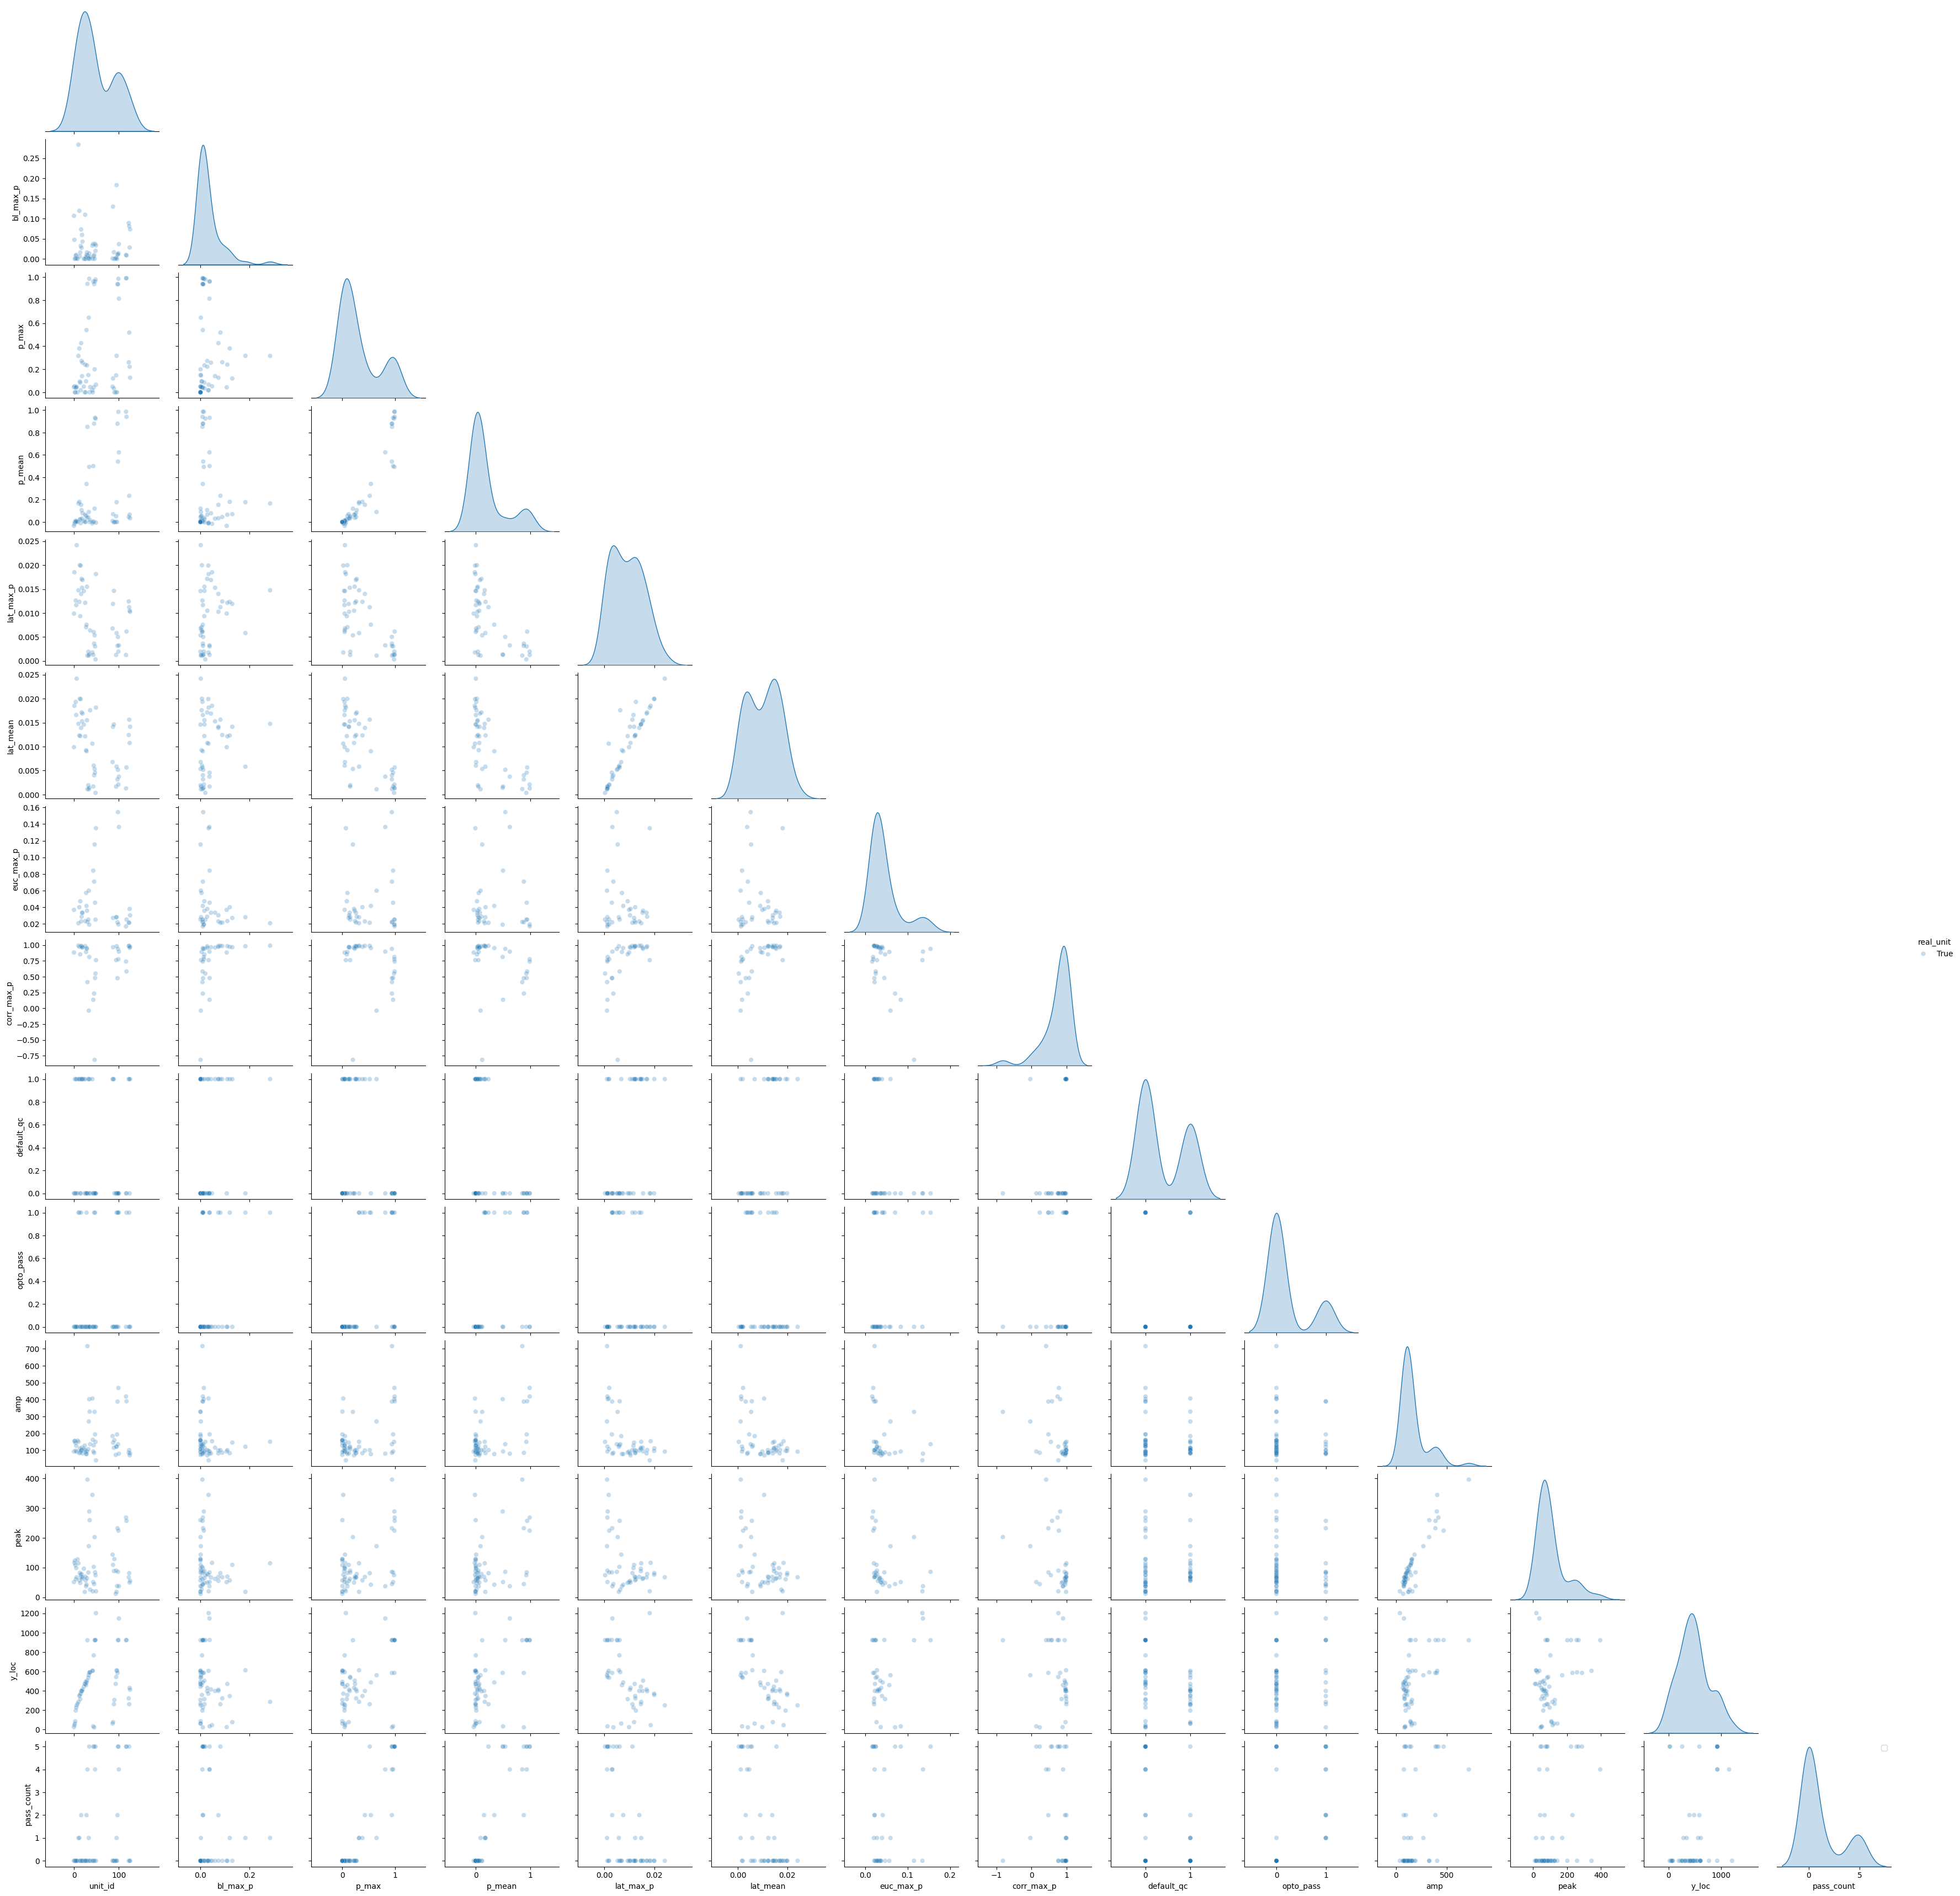

In [253]:
plt.figure(figsize=(10, 10))
opto_tag_tbl_focus = opto_tag_tbl[opto_tag_tbl['y_loc'] < 1500]
sns.pairplot(opto_tag_tbl_focus, hue='real_unit', corner=True, diag_kind='kde', plot_kws={'alpha': 0.25})
plt.legend() 

Text(0.5, 1.0, 'p_max vs peak')

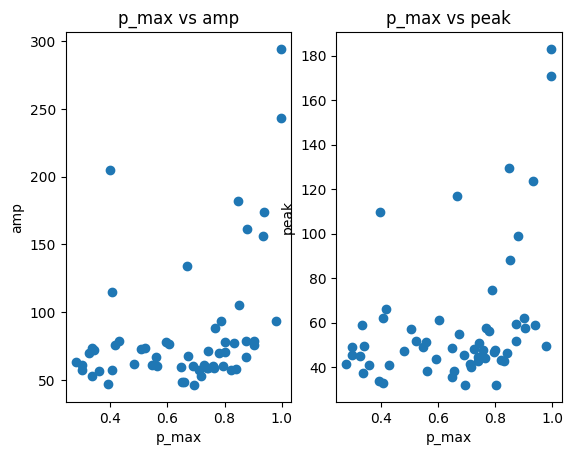

In [201]:
plt.subplot(1, 2, 1)
plt.scatter(opto_tag_tbl[opto_tag_tbl['real_unit'] & (opto_tag_tbl['p_max']>0.25)]['p_max'], opto_tag_tbl[opto_tag_tbl['real_unit'] & (opto_tag_tbl['p_max']>0.25)]['amp'])
plt.xlabel('p_max')
plt.ylabel('amp')
plt.title('p_max vs amp')
plt.subplot(1, 2, 2)
plt.scatter(opto_tag_tbl[opto_tag_tbl['real_unit'] & (opto_tag_tbl['p_max']>0.25)]['p_max'], opto_tag_tbl[opto_tag_tbl['real_unit'] & (opto_tag_tbl['p_max']>0.25)]['peak'])
plt.xlabel('p_max')
plt.ylabel('peak')
plt.title('p_max vs peak')

In [254]:
def get_gradient_colors(max_p_values, floor=0, ceiling=1, cmap_name='Reds'):
    norm = mcolors.Normalize(vmin=floor, vmax=ceiling)
    cmap = cm.get_cmap(cmap_name)  # Use cm.get_cmap instead of colormaps[cmap_name]
    colors = [cmap(norm(max(0, p))) for p in max_p_values]  
    return colors, norm, cmap

/tmp/ipykernel_2718/2143933543.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)  # Use cm.get_cmap instead of colormaps[cmap_name]


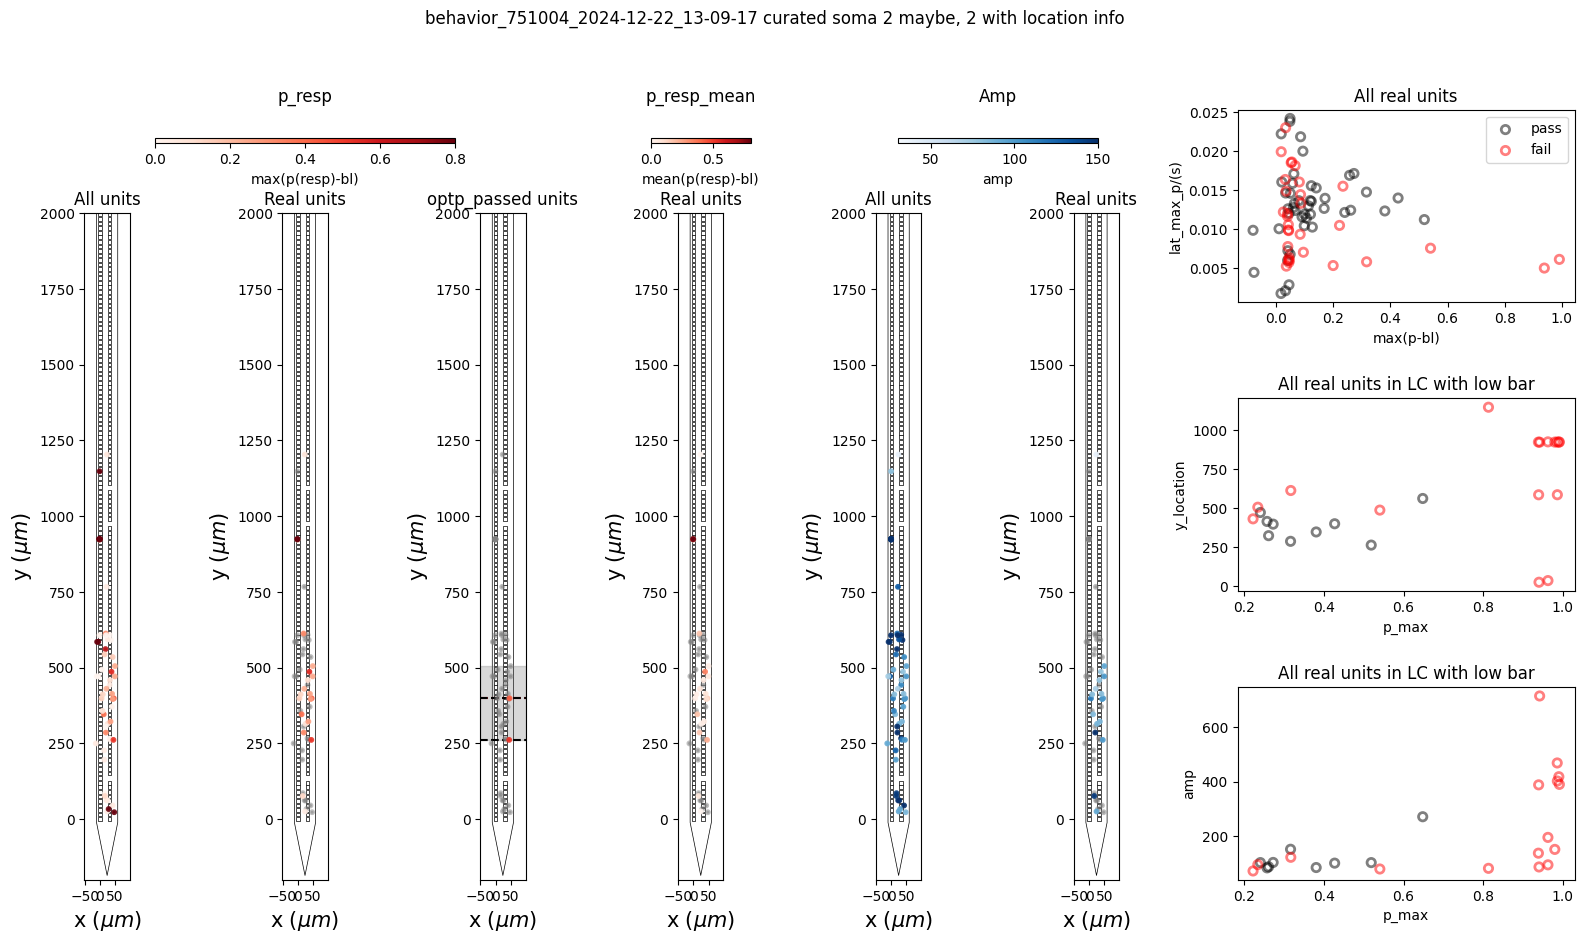

In [293]:
fig = plt.figure(figsize=(20, 10))
gs_probe = gridspec.GridSpec(2, 8, figure=fig, height_ratios=[1, 20])
# p_resp
ax = fig.add_subplot(gs_probe[1, 0])
colors, norm, cmap = get_gradient_colors(opto_tag_tbl['p_max'].values, ceiling=0.8)
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('All units')

ax = fig.add_subplot(gs_probe[1, 1])
unit_ids_filtered = pd.Series(unit_ids)[opto_tag_tbl['real_unit'] & (opto_tag_tbl['lat_mean']>=0.005) & (opto_tag_tbl['euc_max_p']<=0.5)].values.tolist()
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('Real units')

# Define the color map (red gradient)
cmap = plt.get_cmap("Reds")  # Use Reds colormap

# Normalize between 0 and 1
norm = mcolors.Normalize(vmin=0, vmax=0.8)

# Create a colorbar
ax = fig.add_subplot(gs_probe[0, 0:3])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', aspect=60, shrink=2, pad=0.05)
cbar.set_label("max(p(resp)-bl)")
ax.clear()
ax.axis('off')
ax.set_title("p_resp")

# p_resp_mean
colors, norm, cmap = get_gradient_colors(opto_tag_tbl['p_mean'].values, ceiling=0.8)
color_dict = dict(zip(unit_ids, colors))

ax = fig.add_subplot(gs_probe[1, 3])
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('Real units')

# Define the color map (red gradient)
cmap = plt.get_cmap("Reds")  # Use Reds colormap

# Normalize between 0 and 1
norm = mcolors.Normalize(vmin=0, vmax=0.8)

# Create a colorbar
ax = fig.add_subplot(gs_probe[0, 3])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', aspect=20, shrink=2, pad=0.05)
cbar.set_label("mean(p(resp)-bl)")
ax.clear()
ax.axis('off')
ax.set_title("p_resp_mean")

# amp
ax = fig.add_subplot(gs_probe[1, 4])
colors, norm, cmap = get_gradient_colors(opto_tag_tbl['amp'].values, floor = 30, ceiling=150, cmap_name='Blues')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('All units')

ax = fig.add_subplot(gs_probe[1, 5])
unit_ids_filtered = pd.Series(unit_ids)[opto_tag_tbl['real_unit'] & (opto_tag_tbl['lat_mean']>=0.007) & (opto_tag_tbl['euc_max_p']<=0.5)].values.tolist()
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('Real units')

# Define the color map (blue gradient)
cmap = plt.get_cmap("Blues")  # Use
norm = mcolors.Normalize(vmin=30, vmax=150)
ax = fig.add_subplot(gs_probe[0, 4:6])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', aspect=40, shrink=2, pad=0.05)
cbar.set_label("amp")
ax.clear()
ax.axis('off')
ax.set_title("Amp")

# peak, presp

# depth, presp
gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.5)
# top unit pass presp
thresh = 0.2
top = opto_tag_tbl[opto_tag_tbl['p_max']>0.6]['y_loc'].max()
# bottom = opto_tag_tbl[opto_tag_tbl['p_max']>thresh]['y_loc'].min()

ax = fig.add_subplot(gs[0, 3])
focus = (opto_tag_tbl['real_unit']) & (opto_tag_tbl['lat_mean']>0.005)
ax.scatter(opto_tag_tbl[focus & opto_tag_tbl['default_qc']]['p_max'], opto_tag_tbl[focus& opto_tag_tbl['default_qc']]['lat_max_p'], label='pass', alpha=0.5, facecolors='none', edgecolors='k', linewidths=2)
ax.scatter(opto_tag_tbl[focus & ~opto_tag_tbl['default_qc']]['p_max'], opto_tag_tbl[focus& ~opto_tag_tbl['default_qc']]['lat_max_p'], label='fail', alpha=0.5, facecolors='none', edgecolors='r', linewidths=2)
ax.set_xlabel('max(p-bl)')
ax.set_ylabel('lat_max_p/(s)')
ax.set_title('All real units')
ax.legend()


ax = fig.add_subplot(gs[1, 3])
focus = (opto_tag_tbl['real_unit']) & (opto_tag_tbl['y_loc']<=top) & (opto_tag_tbl['p_max']>thresh)
ax.scatter(opto_tag_tbl[focus & opto_tag_tbl['default_qc']]['p_max'], opto_tag_tbl[focus& opto_tag_tbl['default_qc']]['y_loc'], label='pass', alpha=0.5, facecolors='none', edgecolors='k', linewidths=2)
ax.scatter(opto_tag_tbl[focus & ~opto_tag_tbl['default_qc']]['p_max'], opto_tag_tbl[focus& ~opto_tag_tbl['default_qc']]['y_loc'], label='fail', alpha=0.5, facecolors='none', edgecolors='r', linewidths=2)
ax.set_ylabel('y_location')
ax.set_xlabel('p_max')
ax.set_title('All real units in LC with low bar')

ax = fig.add_subplot(gs[2, 3])
# ax.scatter(opto_tag_tbl[focus]['p_max'], opto_tag_tbl[focus]['amp'], c=opto_tag_tbl[focus]['default_qc'])
ax.scatter(opto_tag_tbl[focus & opto_tag_tbl['default_qc']]['p_max'], opto_tag_tbl[focus& opto_tag_tbl['default_qc']]['amp'], label='pass', alpha=0.5, facecolors='none', edgecolors='k', linewidths=2)
ax.scatter(opto_tag_tbl[focus & ~opto_tag_tbl['default_qc']]['p_max'], opto_tag_tbl[focus& ~opto_tag_tbl['default_qc']]['amp'], label='fail', alpha=0.5, facecolors='none', edgecolors='r', linewidths=2)
ax.set_ylabel('amp')
ax.set_xlabel('p_max')
ax.set_title('All real units in LC with low bar')

low_thresh = 0.3
high_thresh = 0.5
mid_thresh = 0.4

unit_tag = (opto_tag_tbl['p_max']>mid_thresh) & (opto_tag_tbl['p_mean']>0.1) & (opto_tag_tbl['pass_count'] >=2) &\
            (opto_tag_tbl['lat_max_p']<0.02) & (opto_tag_tbl['lat_max_p']>0.007) &\
            (opto_tag_tbl['bl_max_p']>0.5*0.02) * (opto_tag_tbl['bl_max_p']<20*0.02) &\
            (opto_tag_tbl['real_unit']) &\
            (opto_tag_tbl['euc_max_p']<=0.3)

mask = (opto_tag_tbl['p_max']>0.2)&\
            (opto_tag_tbl['lat_max_p']<0.025) & (opto_tag_tbl['lat_max_p']>0.007) &\
            (opto_tag_tbl['bl_max_p']>0.5*0.02) * (opto_tag_tbl['bl_max_p']<10*0.02) &\
            (opto_tag_tbl['real_unit']) &\
            (opto_tag_tbl['euc_max_p']<=0.3)

center = np.quantile(opto_tag_tbl[mask]['y_loc'].values, 0.5)
LC_range = opto_tag_tbl[mask]['y_loc'].values

top = opto_tag_tbl[unit_tag]['y_loc'].max()
bottom = opto_tag_tbl[unit_tag]['y_loc'].min()
top = np.min([top, center+500])
bottom = np.max([bottom, center-500])
unit_tag_loc = (opto_tag_tbl['p_max']>=low_thresh) & (opto_tag_tbl['p_mean']>0.1) & (opto_tag_tbl['pass_count'] >=2) & \
            (opto_tag_tbl['y_loc']<=top) & (opto_tag_tbl['y_loc']>=bottom) & \
            (opto_tag_tbl['lat_max_p']<0.02) & (opto_tag_tbl['lat_max_p']>0.007) & \
            (opto_tag_tbl['bl_max_p']>0.5*0.02) * (opto_tag_tbl['bl_max_p']<20*0.02)& \
            (opto_tag_tbl['real_unit']) &\
            (opto_tag_tbl['euc_max_p']<=0.3)

# passed units:
unit_passed = opto_tag_tbl[unit_tag_loc]['unit_id'].values
ax = fig.add_subplot(gs_probe[1, 2])

colors, norm, cmap = get_gradient_colors(opto_tag_tbl['p_max'].values, ceiling=0.8)
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_passed, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('optp_passed units')
w.ax.axhline(center, color='r', linestyle='--')
# w.ax.axhline(np.max(LC_range), color=[0.4, 0.4, 0.4], linewidth=3, alpha = 0.25)
# w.ax.axhline(np.min(LC_range), color=[0.4, 0.4, 0.4], linewidth=3, alpha = 0.25)
w.ax.fill_between([-50, 100], np.max(LC_range), np.min(LC_range), color=[0.4, 0.4, 0.4], alpha=0.25)
w.ax.axhline(top, color='k', linestyle='--')
w.ax.axhline(bottom, color='k', linestyle='--')

plt.suptitle(f'{session} {data_type} {target} {np.sum(unit_tag)} maybe, {np.sum(unit_tag_loc)} with location info')

plt.show()


In [262]:
opto_tag_tbl[opto_tag_tbl['real_unit'] & (opto_tag_tbl['lat_mean']>0.005) & (opto_tag_tbl['y_loc']<750)]

,unit_id,bl_max_p,p_max,p_mean,lat_max_p,lat_mean,euc_max_p,corr_max_p,default_qc,opto_pass,amp,peak,decoder_label,real_unit,y_loc,pass_count
0,0,0.107055,0.042945,-0.035069,0.009886,0.009886,0.036974,0.883428,False,False,92.141026,51.179325,noise,True,25.258900,0
1,1,0.047349,0.052651,-0.016526,0.018512,0.018512,NaN,NaN,False,False,153.542603,115.892006,mua,True,45.022810,0
4,4,0.008105,0.041895,0.011895,0.012608,0.019325,NaN,NaN,True,False,96.486382,60.620022,sua,True,196.081567,0
5,5,0.010056,0.039944,0.004714,0.011653,0.016590,NaN,NaN,False,False,126.526194,98.452042,mua,True,226.768977,0
6,6,0.001278,0.048722,0.004418,0.024175,0.024175,NaN,NaN,True,False,91.429663,67.458694,mua,True,249.799257,0
8,10,0.283909,0.316091,0.166091,0.014746,0.014746,0.020935,0.992668,True,True,150.037342,114.415520,sua,True,285.656091,1
9,12,0.119518,0.380482,0.180482,0.012328,0.012328,0.040132,0.974387,True,True,82.485010,57.017632,sua,True,345.943379,1
10,13,0.006293,0.093707,0.022406,0.019985,0.019985,NaN,NaN,True,False,111.146461,81.695213,mua,True,357.116278,0
11,14,0.015905,0.084095,0.024095,0.009339,0.012189,0.047335,0.854568,False,False,86.696999,48.296417,noise,True,314.397508,0
12,15,0.032198,0.017802,-0.011127,0.019914,0.019914,NaN,NaN,False,False,95.729397,76.051163,sua,True,370.732190,0


In [288]:
# mask = (opto_tag_tbl['p_max']>0.2)&\
#             (opto_tag_tbl['lat_max_p']<0.025) & (opto_tag_tbl['lat_max_p']>0.007) &\
#             (opto_tag_tbl['bl_max_p']>0.5*0.02) * (opto_tag_tbl['bl_max_p']<10*0.02) &\
#             (opto_tag_tbl['real_unit']) &\
#             (opto_tag_tbl['euc_max_p']<=0.3)
opto_tag_tbl[mask]

,unit_id,bl_max_p,p_max,p_mean,lat_max_p,lat_mean,euc_max_p,corr_max_p,default_qc,opto_pass,amp,peak,decoder_label,real_unit,y_loc,pass_count
9,12,0.119518,0.380482,0.180482,0.012328,0.012328,0.040132,0.974387,True,True,82.485010,57.017632,sua,True,345.943379,1
13,16,0.073144,0.426856,0.153390,0.013986,0.013902,0.023125,0.989347,True,True,98.752682,68.536263,sua,True,398.654471,2
14,17,0.027643,0.272357,0.106016,0.017127,0.017127,0.028823,0.981450,True,False,101.330166,78.344353,mua,True,396.104434,0
16,19,0.042975,0.257025,0.078474,0.016892,0.016892,0.033485,0.967026,True,False,81.227226,66.799957,sua,True,413.445781,0
19,25,0.109760,0.240240,0.064672,0.012139,0.012139,0.023500,0.985303,True,False,100.787292,69.563499,mua,True,471.052257,0
23,29,0.016144,0.233856,0.036804,0.015496,0.015496,0.035917,0.942788,False,False,93.318052,64.201431,mua,True,505.015723,0
106,122,0.089062,0.260938,0.044668,0.012420,0.012420,0.021745,0.986132,True,False,85.304112,67.365913,sua,True,322.034106,0
107,123,0.081261,0.518739,0.234179,0.011224,0.015622,0.021462,0.989769,True,True,100.711626,81.174757,sua,True,261.428084,5
108,124,0.028139,0.221861,0.065768,0.010478,0.010754,0.038097,0.958725,False,False,69.780589,49.633484,noise,True,430.161112,0
